In [297]:
#documentation: https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html

from sklearn.ensemble import RandomForestClassifier
from python_speech_features import mfcc
from python_speech_features import logfbank
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import scipy.io.wavfile as wav
import glob
import sys
import numpy as np
import parselmouth
import math
import scipy
import matplotlib.pyplot as plt
import librosa

In [298]:
import os

if os.getcwd().endswith("Calculator") == True or \
   os.getcwd().endswith("Calculator\\") == True or \
   os.getcwd().endswith("Calculator/") == True :
    cwd = os.getcwd()

print(cwd)

C:\Users\qan96\Documents\GitHub\Audio-Calculator


In [414]:
def join_features(mfcc, fbank):
    features = np.concatenate((mfcc, fbank), axis=1)
    return features

truncate_threshold = 0.1
truncate_size = 10000.0
pre_emphasis = 0.97

def normalize(signal):
    result = abs(signal).copy().astype('float64')
    xmin = np.min(result)
    xmax = np.max(result)
    for i in range(0, signal.size):
        result[i] = (result[i] - xmin) / (xmax - xmin)
        result[i] = "%.2f" % result[i]
    
    return result

def calculate_normalized_entropy(signal):
    #normalize
    signal = normalize(signal)
    
    p = np.zeros(101)
    for i in range(0, signal.size):
        p[(signal[i] / 0.01).astype('int64')] += 1
    
    p = p / signal.size
    max_entro = 0.0
    min_entro = 1.0
    entropy = np.zeros(signal.size)
    
    for i in range(0, signal.size):
        index = (signal[i] / 0.01).astype('int64')
        entropy[i] = -p[index]*math.log2(p[index])
        max_entro = max(max_entro, entropy[i])
        min_entro = min(min_entro, entropy[i])
        
    for i in range(0,100):
        if p[i] == 0:
            continue
        #print(-p[i]*math.log2(p[i]))
        
    lamb = (max_entro - min_entro) / 2.0
    return entropy, lamb
    
def plot_sig(sig, ylabel):
    plt.figure()
    plt.plot(sig)
    plt.xlabel("time [s]")
    plt.ylabel(ylabel)
    plt.show()

def preprocess(sig):
    #sig = np.append(sig[0], sig[1:] - pre_emphasis * sig[:-1])
    
    start_point = 0
    threshold = 0.1
    norm_sig = normalize(sig)
    np.set_printoptions(threshold=sys.maxsize)
    
    for i in range(0, sig.size):
        if norm_sig[i] >= truncate_threshold:
            start_point = i
            break
    
    stop_point = sig.size
    for i in reversed(range(0, sig.size)):
        if norm_sig[i] >= (truncate_threshold):
            stop_point = i
            break
    
    #print("start point", start_point)
    #print("stop point", stop_point)
    sig = sig[start_point:stop_point]
    #print(sig.size)
    
    #strech sig to 6000
    sig = librosa.core.resample(sig, sig.size, truncate_size)
    
    #sig = truncate_sig(sig)
    
    return sig
    
def read_file(files, label, enable_plot):
    features = []
    labels = []
    for file in files:
        (rate,sig) = wav.read(file)
        
        #plot_sig(sig, amplitude)
        
        sig, sample_rate = librosa.core.load(file)
        #sample_rate, sig = scipy.io.wavfile.read(file)  # File assumed to be in the same directory
        
        #entropy, lamb = calculate_normalized_entropy(sig)
        
        if enable_plot == True:
            plot_sig(sig, "before")
        sig = preprocess(sig)
        
        mfcc_feat = mfcc(sig, rate, nfft=1536)
        fbank_feat = logfbank(sig, rate, nfft=1536)
            
        acoustic_features = join_features(mfcc_feat, fbank_feat)
        acoustic_features = acoustic_features.flatten()
        features.append(acoustic_features)
        labels.append(label)
        if enable_plot == True:
            plot_sig(sig, "after")
        
    return features, labels
        
digit_feature_types = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight",\
                 "nine"]

feature_types = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight",\
                 "nine", "plus", "minus", "times", "over"]

operator_feature_types = ["plus", "minus", "times", "over"]

In [ ]:
digit_features = []
digit_labels = []
op_features = []
op_labels = []
for i in digit_feature_types:
    if sys.platform.startswith('win32'):
         os.chdir(cwd+"\\recording data\\" + i + "\\")
    elif sys.platform.startswith('darwin'):
         os.chdir(cwd+"/recording data/" + i + "/")
    
    files = glob.glob(os.path.join(os.getcwd(), '*.wav') )
    features, labels = read_file(files, i, False)
    digit_features.extend(features)
    digit_labels.extend(labels)
    print(i, "finished")

for i in operator_feature_types:
    if sys.platform.startswith('win32'):
         os.chdir(cwd+"\\recording data\\" + i + "\\")
    elif sys.platform.startswith('darwin'):
         os.chdir(cwd+"/recording data/" + i + "/")
    
    files = glob.glob(os.path.join(os.getcwd(), '*.wav') )
    features, labels = read_file(files, i, False)
    op_features.extend(features)
    op_labels.extend(labels)
    
    print(i, "finished")
    
print("Input and preprocessing finished")

zero finished
one finished
two finished
three finished


In [400]:
digit_features = np.asarray(digit_features)
digit_labels = np. asarray(digit_labels)
op_features = np.asarray(op_features)
op_labels = np. asarray(op_labels)

print(digit_features.shape)
print(digit_labels.shape)

print(op_features.shape)
print(op_labels.shape)

(200, 4836)
(200,)
(89, 4836)
(89,)


In [401]:
#validate features and labels
for i in range(1, digit_features.shape[0]):
    if digit_features[i].size != digit_features[0].size:
        print("digit features", i)
        print(digit_features[i].size)
    if digit_labels[i].size != 1:
        print("digit labels", i)
        print(digit_labels[i].size)


digit_train_set, digit_test_set, digit_train_label, digit_test_label = train_test_split(digit_features, digit_labels, test_size=1.0/7.0, random_state=0, stratify=digit_labels)
op_train_set, op_test_set, op_train_label, op_test_label = train_test_split(op_features, op_labels, test_size=1.0/7.0, random_state=0, stratify=op_labels)

In [402]:
digit_logisticRegr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', penalty = 'l2')

digit_logisticRegr.fit(digit_train_set, digit_train_label)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'zero'

In [403]:
# Predict for One Observation (image)

print(digit_test_set.shape[0])
for i in range(0, digit_test_set.shape[0]):
    if test_label[i] in digit_feature_types:
        result = logisticRegr.predict(digit_test_set[i].reshape(1,-1))
        if (result != digit_test_label[i]):
            print("Correct result:" + digit_test_label[i])
            print(result)
    
print(logisticRegr.score(digit_test_set, digit_test_label))
print(logisticRegr.score(digit_train_set, digit_train_label))

29


ValueError: X has 4836 features per sample; expecting 2886

In [248]:
rfc = RandomForestClassifier(n_estimators = 150)
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=10, shuffle = True, stratify=labels)
rfc.fit(X_train, y_train)
#more functions from LightGBM baseline: https://www.kaggle.com/opanichev/lightgbm-baseline
def proba2labels(preds, i2c, k=3):
    ans = []
    ids = []
    for p in preds:
        idx = np.argsort(p)[::-1]
        ids.append([i for i in idx[:k]])
        ans.append(' '.join([i2c[i] for i in idx[:k]]))

    return ans, ids
#checking the accuracy of the model
print(rfc.score(X_val, y_val))

0.9725


In [281]:
def read_and_test_file(directory):
    os.chdir(cwd+"\\recording data\\"+directory)
    files = glob.glob(os.path.join(os.getcwd(), '*.wav') )
    for file in files:
        (rate,sig) = wav.read(file)
        plot_sig(sig, "Amplitude before truncation")
        sig = preprocess(sig)
        plot_sig(sig, "Amplitude after truncation")
        mfcc_feat = mfcc(sig, rate, nfft=1536)
        fbank_feat = logfbank(sig, rate, nfft=1536)

        acoustic_features = mfcc_feat
        acoustic_features = join_features(mfcc_feat, fbank_feat)
        acoustic_features = acoustic_features.flatten()
        logistic_result = logisticRegr.predict(acoustic_features.reshape(1,-1))
        rf_result = rfc.predict(acoustic_features.reshape(1,-1))
        print(file)
        print("logistic: ")
        print(logistic_result)
        print("random forest: ")
        print(rf_result)

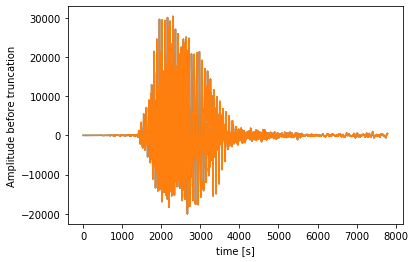

start point 3480
stop point 15584
12104


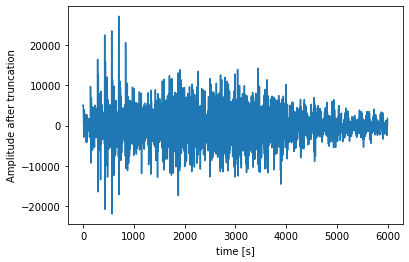

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\minus-Yuhan-0.wav
logistic: 
['five']
random forest: 
['five']


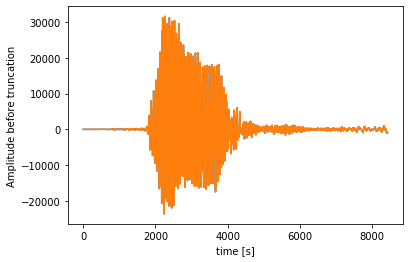

start point 4010
stop point 16864
12854


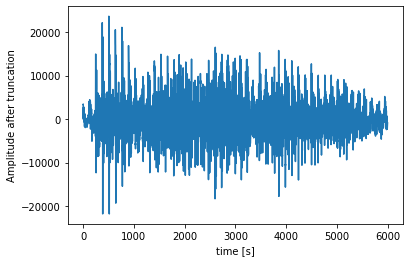

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\minus-Yuhan-1.wav
logistic: 
['seven']
random forest: 
['nine']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


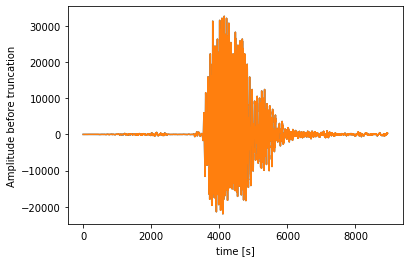

start point 7334
stop point 17888
10554


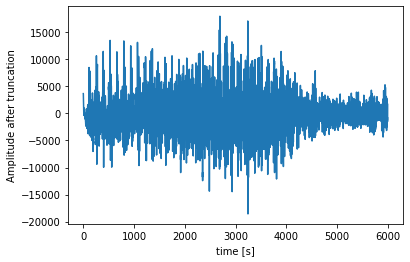

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\minus-Yuhan-10.wav
logistic: 
['nine']
random forest: 
['five']


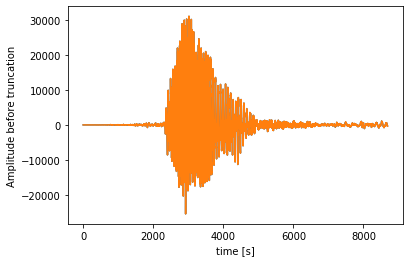

start point 4962
stop point 17376
12414


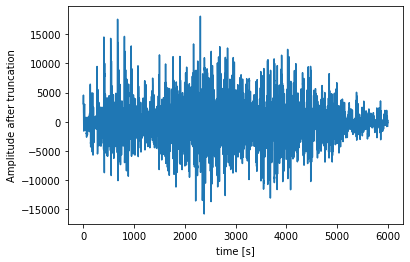

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\minus-Yuhan-2.wav
logistic: 
['one']
random forest: 
['five']


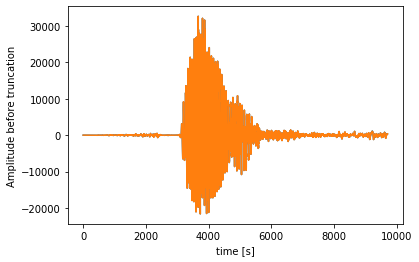

start point 6528
stop point 19424
12896


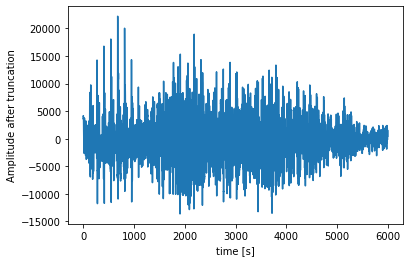

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\minus-Yuhan-3.wav
logistic: 
['one']
random forest: 
['five']


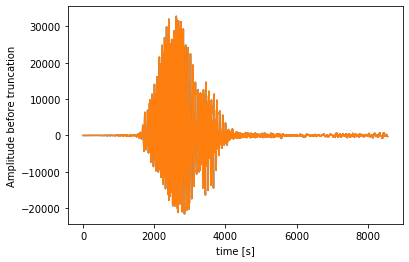

start point 3726
stop point 17120
13394


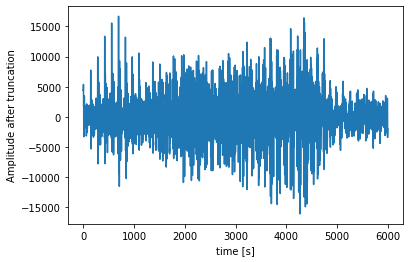

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\minus-Yuhan-4.wav
logistic: 
['nine']
random forest: 
['five']


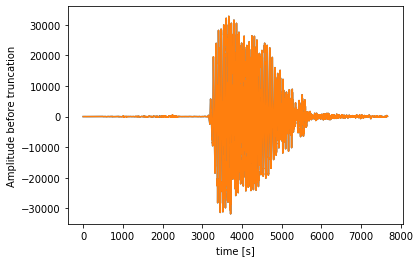

start point 6524
stop point 15328
8804


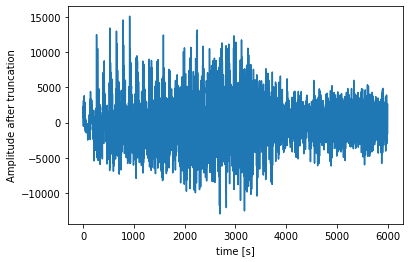

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\minus-Yuhan-5.wav
logistic: 
['nine']
random forest: 
['five']


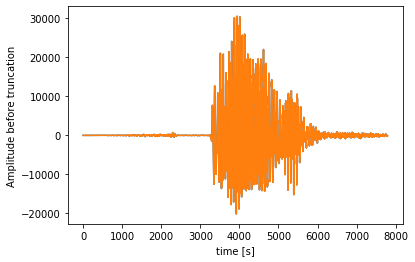

start point 6718
stop point 15584
8866


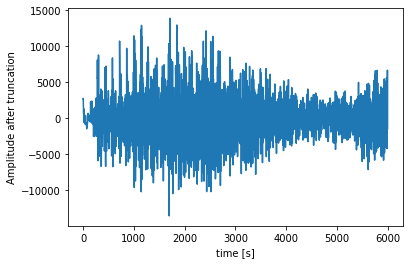

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\minus-Yuhan-6.wav
logistic: 
['nine']
random forest: 
['nine']


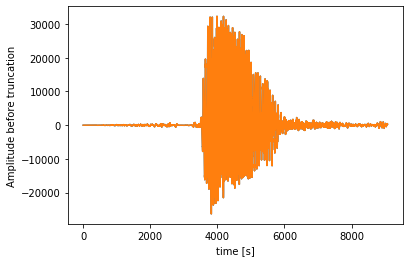

start point 7252
stop point 18144
10892


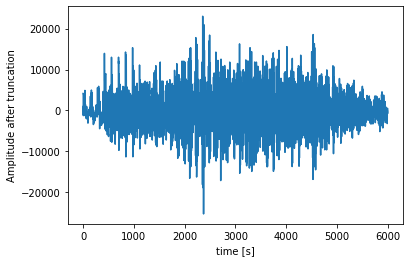

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\minus-Yuhan-7.wav
logistic: 
['nine']
random forest: 
['five']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


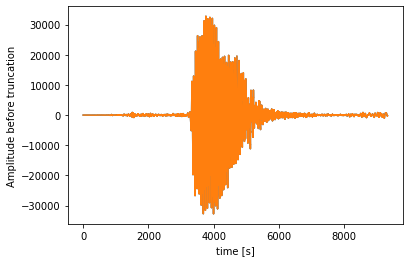

start point 6736
stop point 18656
11920


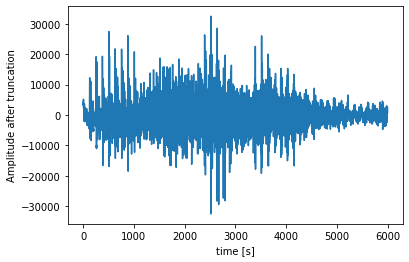

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\minus-Yuhan-8.wav
logistic: 
['nine']
random forest: 
['nine']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


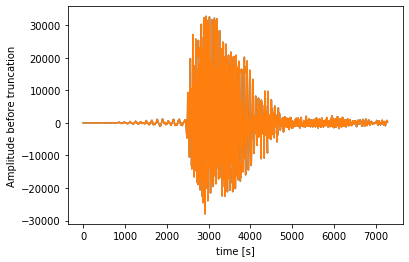

start point 5100
stop point 14560
9460


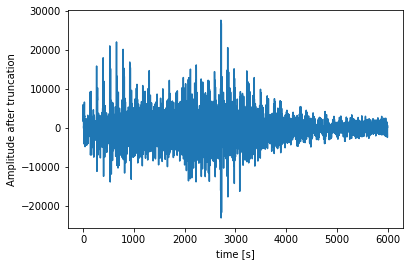

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\minus-Yuhan-9.wav
logistic: 
['nine']
random forest: 
['nine']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


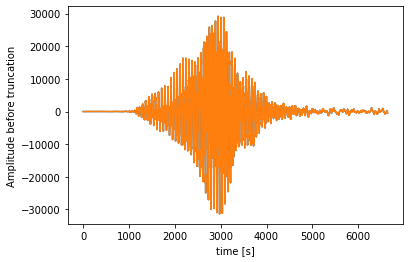

start point 2854
stop point 13280
10426


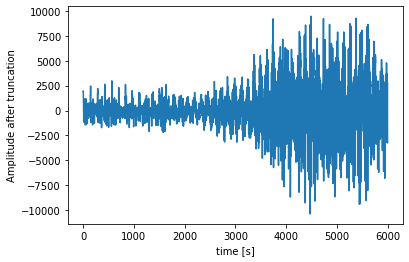

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\over-Yuhan-0.wav
logistic: 
['seven']
random forest: 
['zero']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


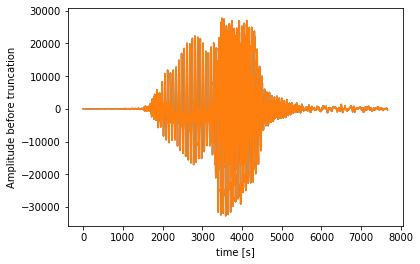

start point 3810
stop point 15328
11518


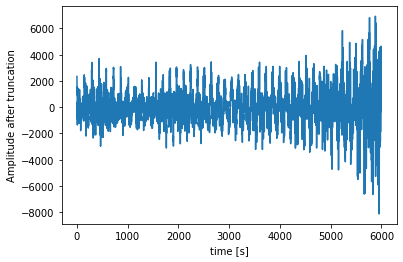

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\over-Yuhan-1.wav
logistic: 
['seven']
random forest: 
['zero']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


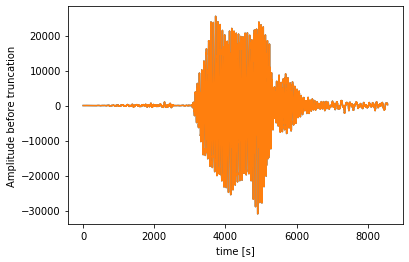

start point 6390
stop point 17120
10730


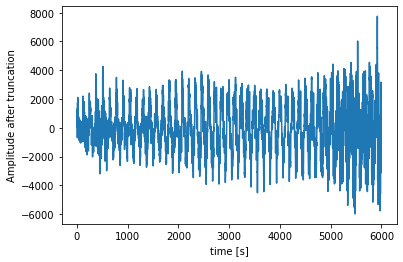

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\over-Yuhan-10.wav
logistic: 
['seven']
random forest: 
['seven']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


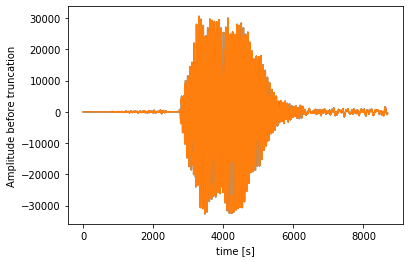

start point 5694
stop point 17376
11682


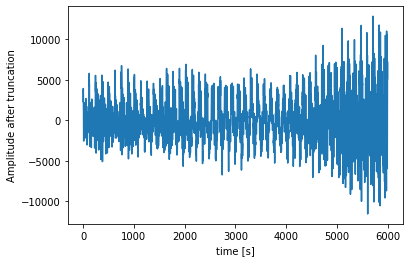

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\over-Yuhan-2.wav
logistic: 
['seven']
random forest: 
['zero']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


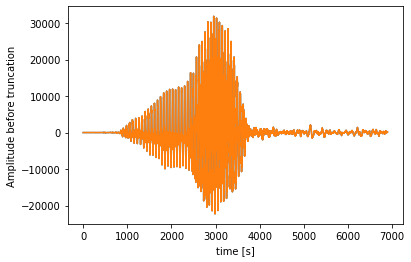

start point 2802
stop point 13792
10990


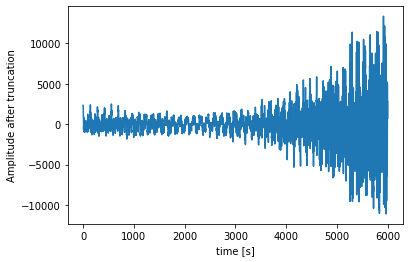

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\over-Yuhan-3.wav
logistic: 
['seven']
random forest: 
['zero']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


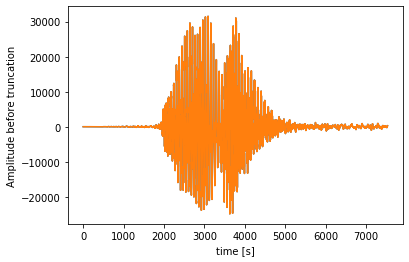

start point 3948
stop point 15072
11124


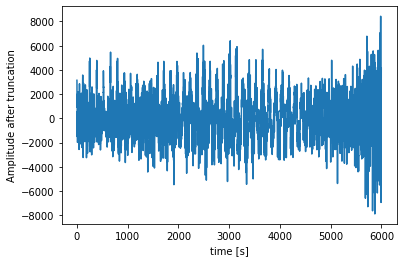

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\over-Yuhan-4.wav
logistic: 
['seven']
random forest: 
['nine']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


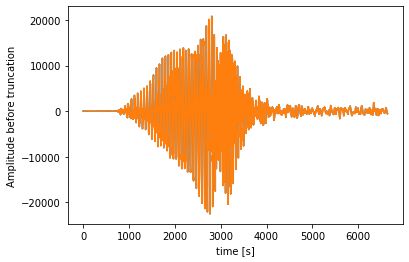

start point 2644
stop point 13280
10636


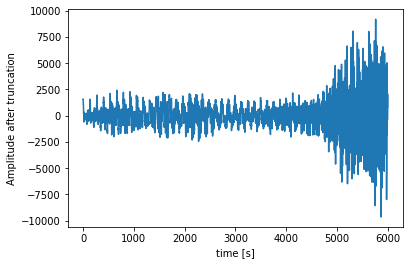

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\over-Yuhan-5.wav
logistic: 
['seven']
random forest: 
['zero']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


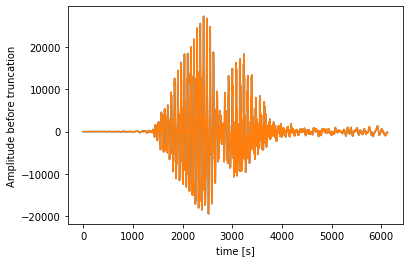

start point 3122
stop point 12256
9134


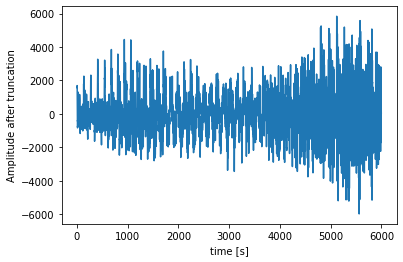

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\over-Yuhan-6.wav
logistic: 
['seven']
random forest: 
['zero']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


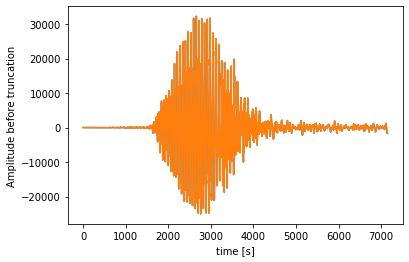

start point 3504
stop point 14304
10800


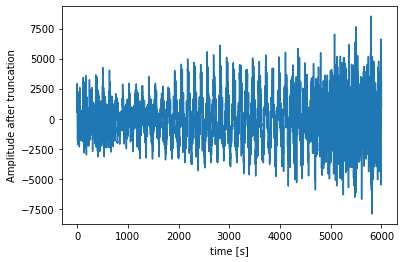

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\over-Yuhan-7.wav
logistic: 
['seven']
random forest: 
['zero']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


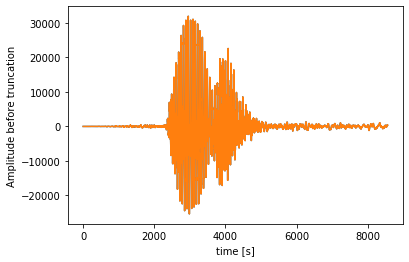

start point 4846
stop point 17120
12274


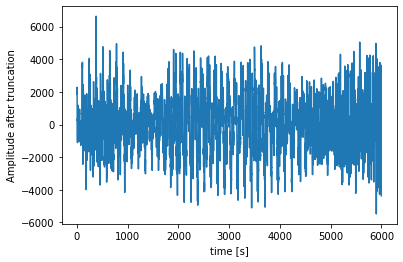

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\over-Yuhan-8.wav
logistic: 
['seven']
random forest: 
['zero']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


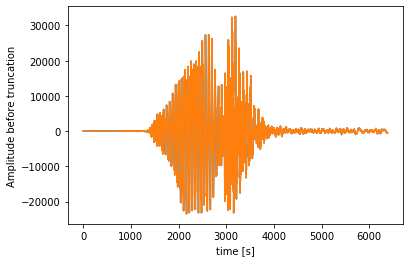

start point 3114
stop point 12768
9654


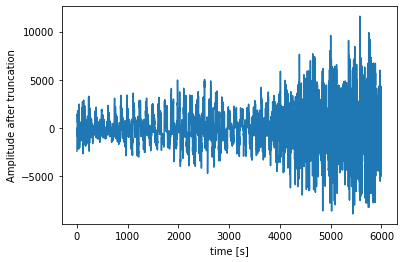

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\over-Yuhan-9.wav
logistic: 
['seven']
random forest: 
['three']


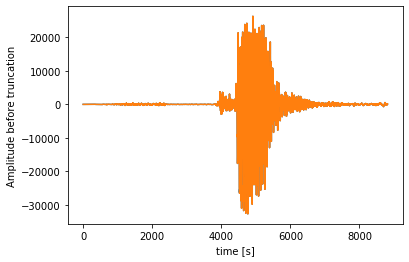

start point 7940
stop point 17632
9692


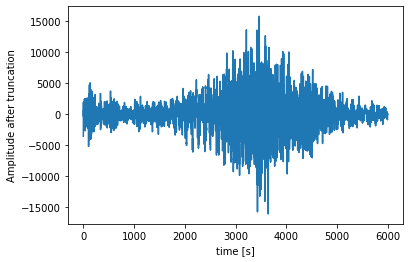

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\plus-Yuhan-0.wav
logistic: 
['nine']
random forest: 
['nine']


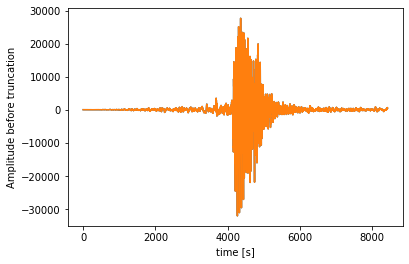

start point 7364
stop point 16864
9500


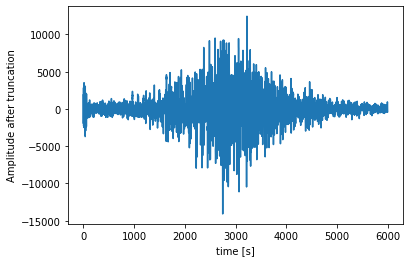

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\plus-Yuhan-1.wav
logistic: 
['seven']
random forest: 
['zero']


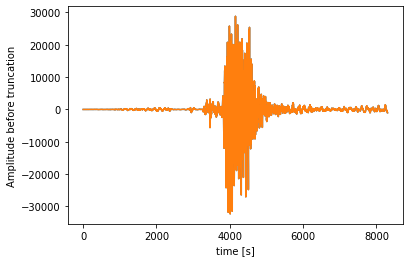

start point 6918
stop point 16608
9690


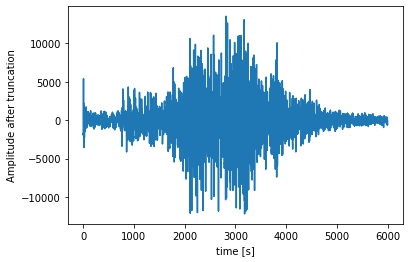

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\plus-Yuhan-10.wav
logistic: 
['seven']
random forest: 
['five']


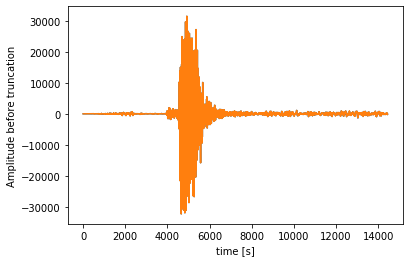

start point 9112
stop point 28896
19784


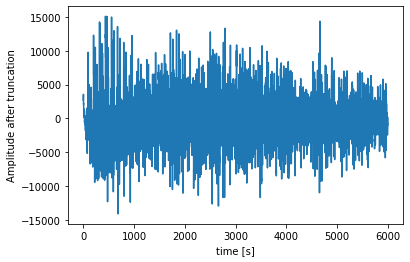

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\plus-Yuhan-2.wav
logistic: 
['seven']
random forest: 
['nine']


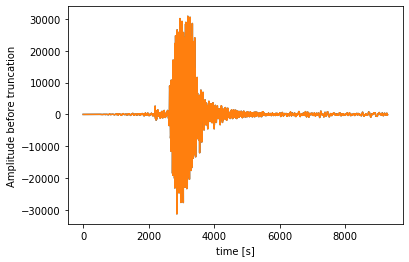

start point 4410
stop point 18576
14166


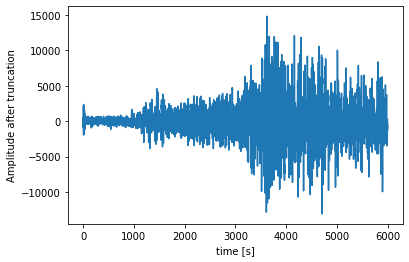

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\plus-Yuhan-3.wav
logistic: 
['five']
random forest: 
['zero']


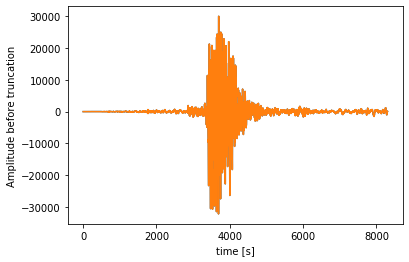

start point 6758
stop point 16608
9850


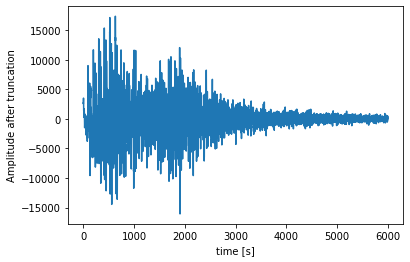

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\plus-Yuhan-4.wav
logistic: 
['seven']
random forest: 
['zero']


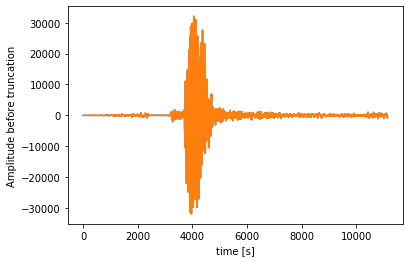

start point 7458
stop point 22292
14834


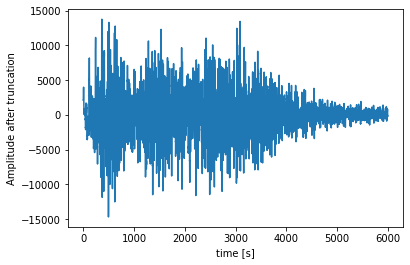

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\plus-Yuhan-5.wav
logistic: 
['seven']
random forest: 
['zero']


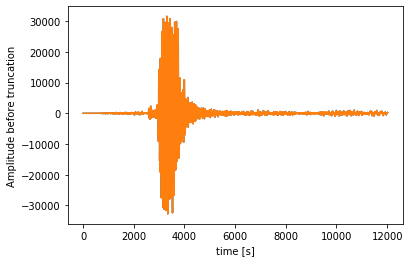

start point 5938
stop point 24032
18094


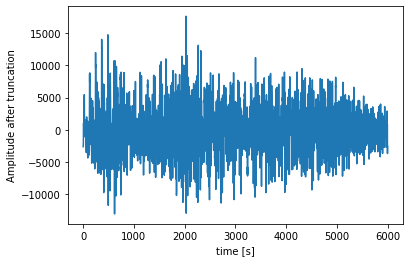

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\plus-Yuhan-6.wav
logistic: 
['seven']
random forest: 
['five']


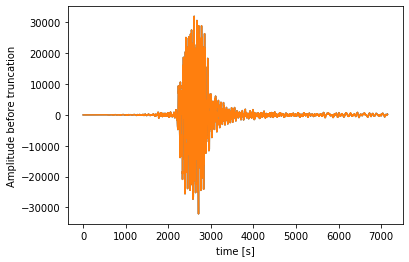

start point 4562
stop point 14304
9742


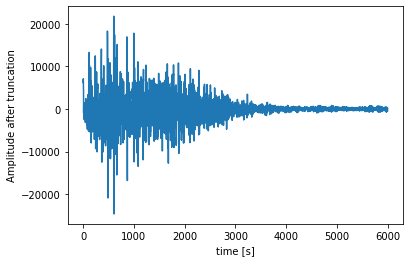

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\plus-Yuhan-7.wav
logistic: 
['seven']
random forest: 
['five']


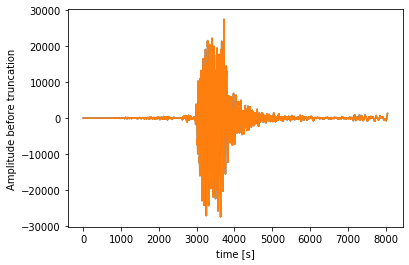

start point 6048
stop point 16096
10048


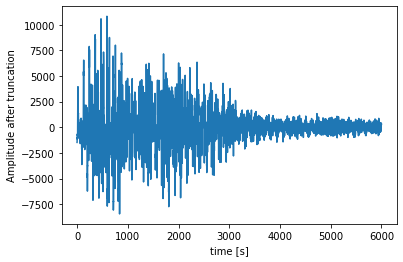

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\plus-Yuhan-8.wav
logistic: 
['seven']
random forest: 
['zero']


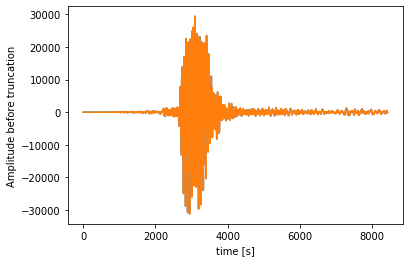

start point 5436
stop point 16864
11428


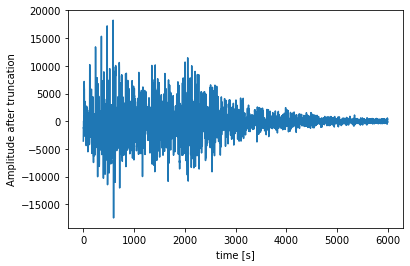

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\plus-Yuhan-9.wav
logistic: 
['seven']
random forest: 
['five']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


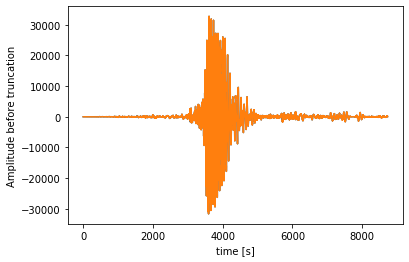

start point 6448
stop point 17462
11014


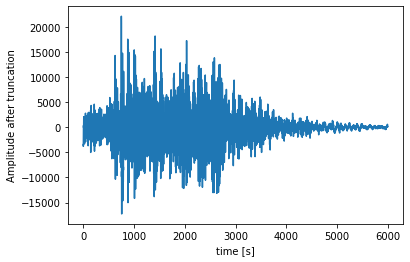

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\times-Yuhan-0.wav
logistic: 
['nine']
random forest: 
['five']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


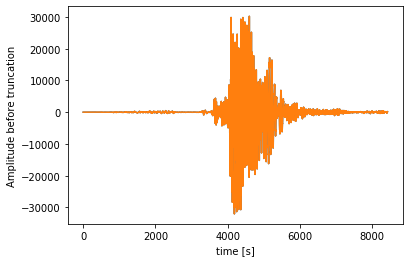

start point 7260
stop point 16864
9604


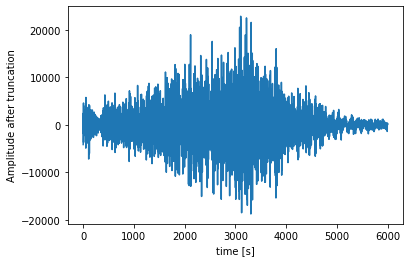

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\times-Yuhan-1.wav
logistic: 
['nine']
random forest: 
['nine']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


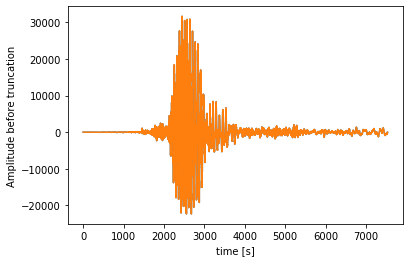

start point 3552
stop point 15072
11520


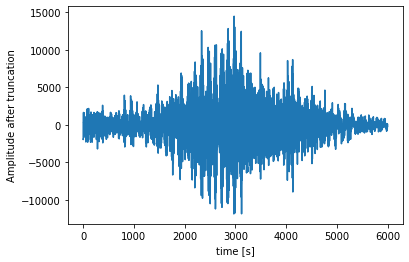

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\times-Yuhan-10.wav
logistic: 
['nine']
random forest: 
['five']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


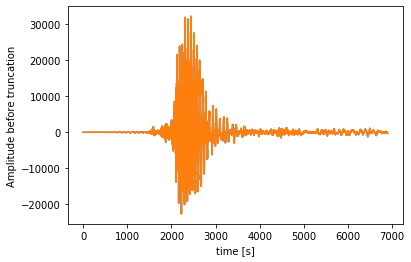

start point 3568
stop point 13792
10224


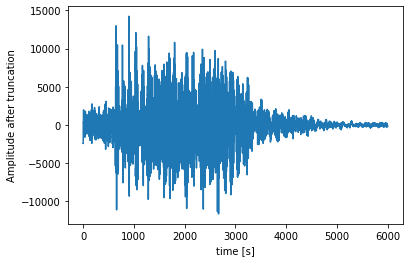

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\times-Yuhan-2.wav
logistic: 
['five']
random forest: 
['nine']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


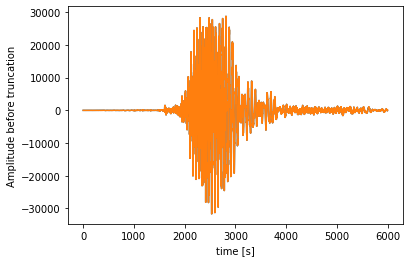

start point 3872
stop point 12000
8128


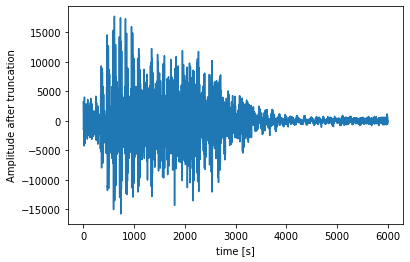

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\times-Yuhan-3.wav
logistic: 
['nine']
random forest: 
['five']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


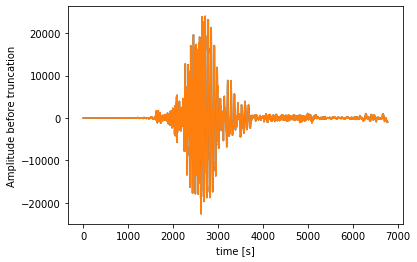

start point 3256
stop point 13536
10280


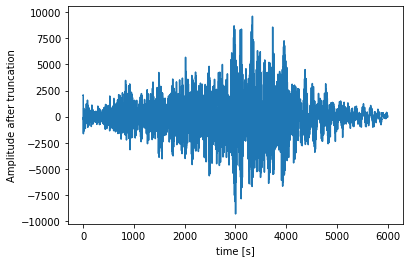

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\times-Yuhan-4.wav
logistic: 
['five']
random forest: 
['nine']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


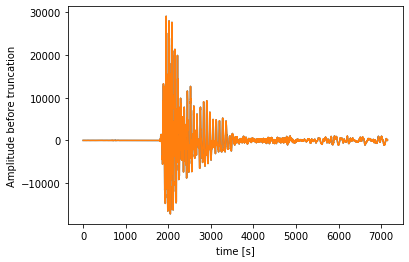

start point 3728
stop point 14304
10576


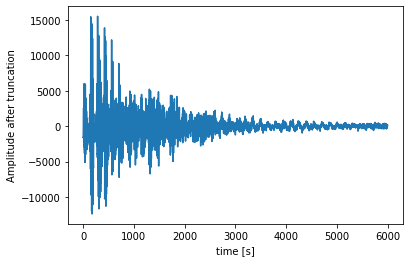

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\times-Yuhan-5.wav
logistic: 
['five']
random forest: 
['five']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


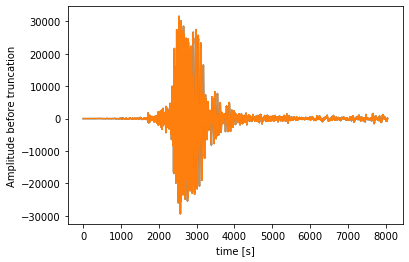

start point 3950
stop point 16096
12146


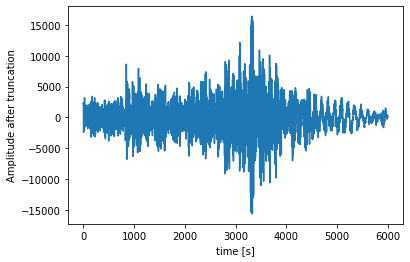

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\times-Yuhan-6.wav
logistic: 
['five']
random forest: 
['five']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


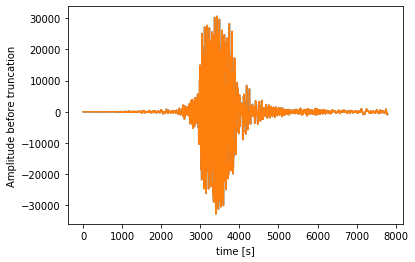

start point 5098
stop point 15584
10486


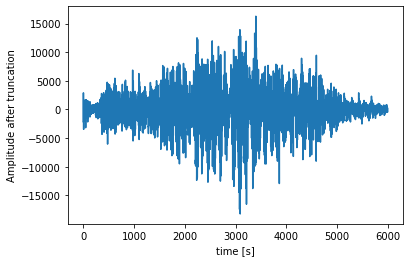

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\times-Yuhan-7.wav
logistic: 
['five']
random forest: 
['nine']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


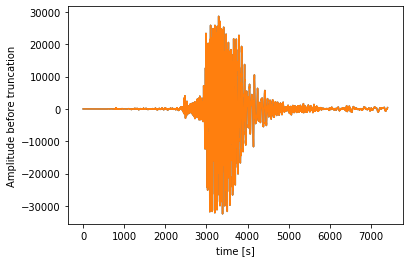

start point 4951
stop point 14816
9865


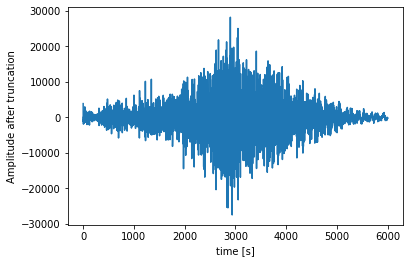

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\times-Yuhan-8.wav
logistic: 
['nine']
random forest: 
['five']


C:\Users\qan96\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


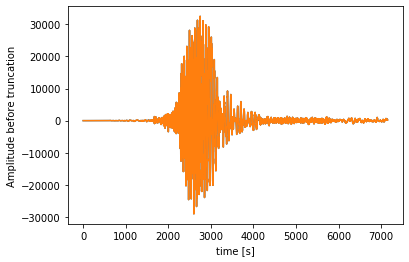

start point 3848
stop point 14304
10456


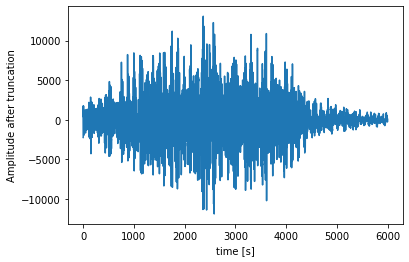

C:\Users\qan96\Documents\GitHub\Audio-Calculator\recording data\Audacity\times-Yuhan-9.wav
logistic: 
['five']
random forest: 
['nine']


In [282]:
read_and_test_file("Audacity")